# Sacrifice Fly Analysis

## Prerequisites

### On Base Data
1. Expected dataset filenames:
    - `/data/throw_home_runner_on_first.parquet`
    - `/data/throw_home_runner_on_second.parquet`
    - `/data/throw_home_runner_on_third.parquet`
2. All datasets include column names from [column names](../data/on_base_column_names.txt)

### Download Top Average Arm Strength

1. Download arm strength csv by year.
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2020&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2021&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2022&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2023&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2024&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2025&minThrows=50&pos=&team=
2. Rename the files to "arm_strength_<year>.csv" e.g. "arm_strength_2020.csv". An improvement would be to scrape the data from Google StatCast or create an equivalent dataset in-house.

### Environment Dependencies

1. Install `uv` python package manager
2. Install and pin a python with version greater than 3.11
3. Run `uv sync` to install project, python dependencies 
4. In the home project directory, run `uv pip install -e .` to install the source packages.

In [1]:
# Install packages from `src`
! uv pip install -e ..
# Sync packages
! uv sync

Using Python 3.13.2 environment at: /Users/william/git/Sacrifice-Fly-Modeling/.venv
Resolved 72 packages in 406ms                                        
   Building sacrifice-fly-modeling @ file:///Users/william/git/Sacrifice-Fly-Modelin
   Building sacrifice-fly-modeling @ file:///Users/william/git/Sacrifice-Fly-Modelin
   Building sacrifice-fly-modeling @ file:///Users/william/git/Sacrifice-Fly-Modelin
      Built sacrifice-fly-modeling @ file:///Users/william/git/Sacrifice-Fly-Modelin
Prepared 1 package in 476ms                                              
Uninstalled 1 package in 0.90ms
Installed 1 package in 1msing==0.1.0 (from file:///Users/wil
 ~ sacrifice-fly-modeling==0.1.0 (from file:///Users/william/git/Sacrifice-Fly-Modeling)
Resolved 100 packages in 1ms
Audited 83 packages in 0.12ms


## Prepare the Data

In [2]:
! uv run ../run/data_prep/data_prep_run.py

Processing runner on third data at: /Users/william/git/Sacrifice-Fly-Modeling/data/throw_home_runner_on_third.parquet
Widened runner on third by fielder features
Filtered runner on third data for plays with less than one out
Merged Sprint data for runner on third by fielder features
Merged arm strength data for runner on third by fielder features
Created Target Feature Successful Sac Fly
Saved data to: /Users/william/git/Sacrifice-Fly-Modeling/data
Processing runner on second data at: /Users/william/git/Sacrifice-Fly-Modeling/data/throw_home_runner_on_second.parquet
Widened runner on second by fielder features
Filtered runner on second data for plays with less than one out
Merged Sprint data for runner on second by fielder features
Merged arm strength data for runner on second by fielder features
Created Target Feature Successful Sac Fly
Saved data to: /Users/william/git/Sacrifice-Fly-Modeling/data


## Importing Project Dependencies

In [8]:
import os
import random
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from models import model_prep_on_base, create_model_pipeline

random.seed(123)

on_base_path = os.path.abspath("../data/throw_home_runner_on_third_wide_sprint_arm.parquet")
on_base_lf = pl.scan_parquet(on_base_path)

## EDA - Runner on Third

### Play Outcome Frequencies


**Definitions**
- Successful when `event_type` was a `sac_fly` or `sac_fly_double_play`
- Unsuccessful when `event_type` was a `field_out` or `double_play`

**Takeaway**
- Successful Sacrifice Fly is the majority case.

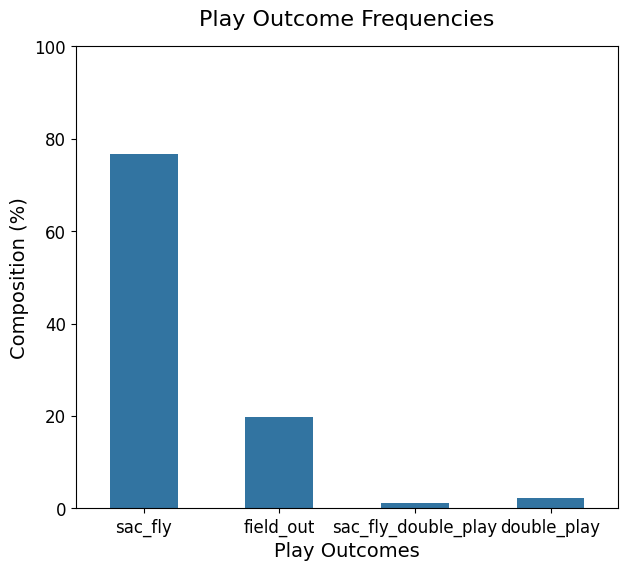

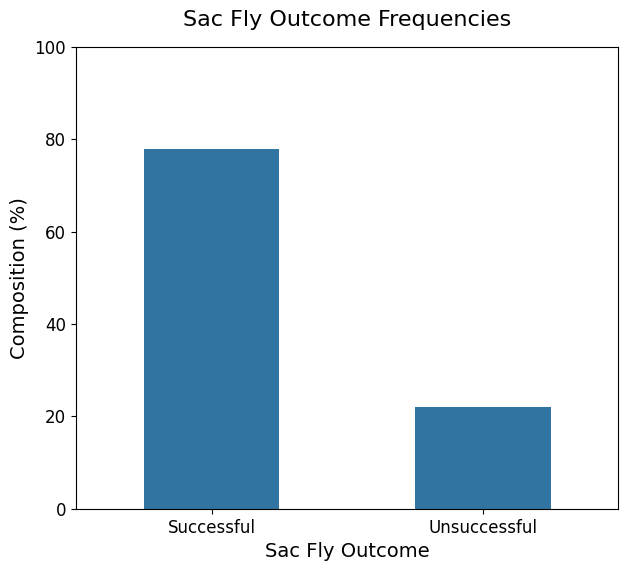

In [4]:
successful_lf = (on_base_lf
    .select(["event_type"])
    .with_columns(
        pl.when(pl.col("event_type").is_in(["sac_fly", "sac_fly_double_play"]))
          .then(pl.lit("Successful"))
          .otherwise(pl.lit("Unsuccessful"))
          .alias("is_successful")
    )
)

successful_pd = successful_lf.collect().to_pandas()

plt.figure(figsize=(7, 6))
sns.countplot(x="event_type", stat = "percent", data=successful_pd, width = .5)
plt.title("Play Outcome Frequencies", fontsize=16, pad=15)
plt.ylim(0, 100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Play Outcomes", fontsize=14)
plt.ylabel("Composition (%)", fontsize=14)
plt.show()

plt.figure(figsize=(7, 6))
sns.countplot(x="is_successful", stat = "percent", data=successful_pd, width = .5)
plt.title("Sac Fly Outcome Frequencies", fontsize=16, pad=15)
plt.ylim(0, 100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Composition (%)", fontsize=14)
plt.show()

## Modeling - Runner on Third

Predicting the probability of Tag Out and evaluating using brier score and log-loss

### All Parameters Unmodified Tag Out

#### Predictors and Grid Search Parameters

In [5]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
    "seconds_since_hit_085_mlb_person_id_R3",
    "arm_overall_fielder_mlb_person_id",
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Unmodified Tag Out

In [6]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

NameError: name 'create_model_pipeline' is not defined

#### Random Forest - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = None
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0449

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.17      0.40      0.24        42

    accuracy                           0.93      1486
   macro avg       0.58      0.67      0.60      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0486
log loss: 0.1488

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_

#### XGBoost - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 10
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.0501

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.16      0.40      0.23        42

    accuracy                           0.92      1486
   macro avg       0.57      0.67      0.60      1486
weighted avg       0.96      0.92      0.94      1486

Brier Score: 0.0554
log loss: 0.1806

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_

#### MLP - All Predictors and Unmodified Tag Out

In [ ]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
    "seconds_since_hit_085_mlb_person_id_R3",
    "arm_overall_fielder_mlb_person_id",
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


### All Parameters and Tag Out Threshold Censoring

#### Predictors and Grid Search

In [ ]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
    "seconds_since_hit_085_mlb_person_id_R3",
    "arm_overall_fielder_mlb_person_id",
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1001

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3323

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = None
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0449

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.17      0.40      0.24        42

    accuracy                           0.93      1486
   macro avg       0.58      0.67      0.60      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0486
log loss: 0.1488

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_

#### XGBoost - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 10
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.0501

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.16      0.40      0.23        42

    accuracy                           0.92      1486
   macro avg       0.57      0.67      0.60      1486
weighted avg       0.96      0.92      0.94      1486

Brier Score: 0.0554
log loss: 0.1806

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_

#### MLP - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multila


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (100, 50)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = adam

Best cross-validation score: -0.0460

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1444
        True       0.09      0.10      0.09        42

    accuracy                           0.95      1486
   macro avg       0.53      0.53      0.53      1486
weighted avg       0.95      0.95      0.95      1486

Brier Score: 0.0484
log loss: 0.5108

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


### Limited Predictors and Tag Out Threshold Censoring

#### Predictors and Grid Search

In [ ]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
  "distance_catch_to_home",
]

num_predictors_median = [
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1001

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3323

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = None
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0449

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.17      0.40      0.24        42

    accuracy                           0.93      1486
   macro avg       0.58      0.67      0.60      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0486
log loss: 0.1488

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_

#### XGBoost - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 10
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.0501

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.16      0.40      0.23        42

    accuracy                           0.92      1486
   macro avg       0.57      0.67      0.60      1486
weighted avg       0.96      0.92      0.94      1486

Brier Score: 0.0554
log loss: 0.1806

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_

#### MLP - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multila


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (100, 50)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = adam

Best cross-validation score: -0.0460

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1444
        True       0.09      0.10      0.09        42

    accuracy                           0.95      1486
   macro avg       0.53      0.53      0.53      1486
weighted avg       0.95      0.95      0.95      1486

Brier Score: 0.0484
log loss: 0.5108

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


### Limited Predictors and Unmodified Tag Outs

#### Predictors and Grid Search

In [ ]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
  "distance_catch_to_home",
]

num_predictors_median = [
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1001

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3323

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = None
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0449

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.17      0.40      0.24        42

    accuracy                           0.93      1486
   macro avg       0.58      0.67      0.60      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0486
log loss: 0.1488

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_

#### XGBoost - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 10
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.0501

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.16      0.40      0.23        42

    accuracy                           0.92      1486
   macro avg       0.57      0.67      0.60      1486
weighted avg       0.96      0.92      0.94      1486

Brier Score: 0.0554
log loss: 0.1806

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_

#### MLP - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multila


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (100, 50)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = adam

Best cross-validation score: -0.0460

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1444
        True       0.09      0.10      0.09        42

    accuracy                           0.95      1486
   macro avg       0.53      0.53      0.53      1486
weighted avg       0.95      0.95      0.95      1486

Brier Score: 0.0484
log loss: 0.5108

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out
